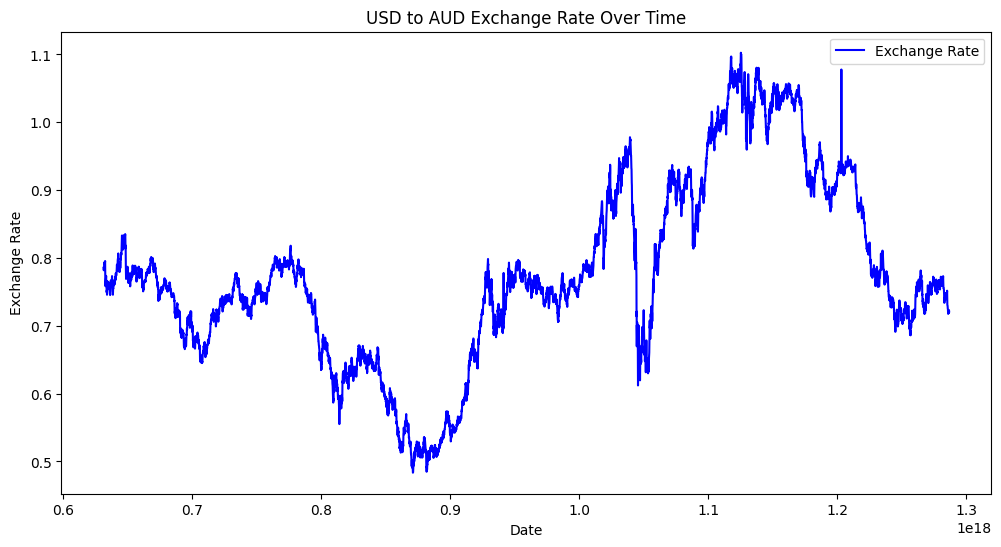

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
The data is not stationary, differencing needed.


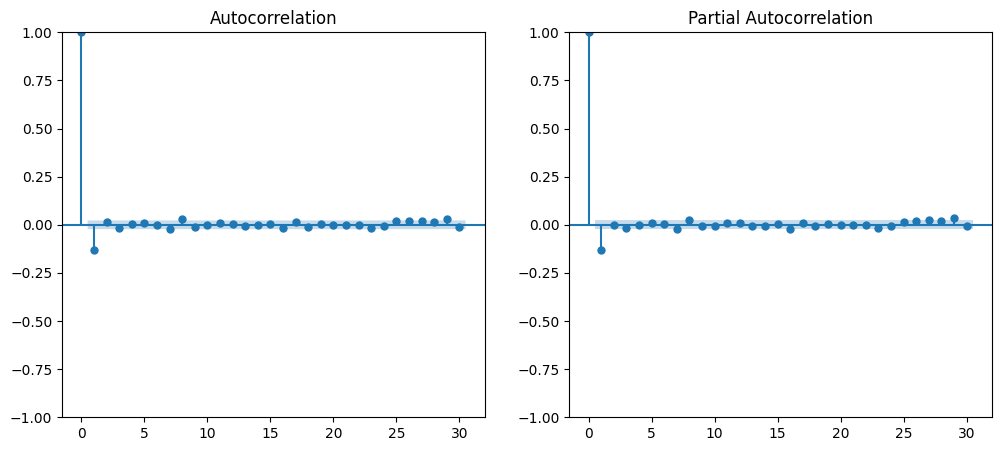

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

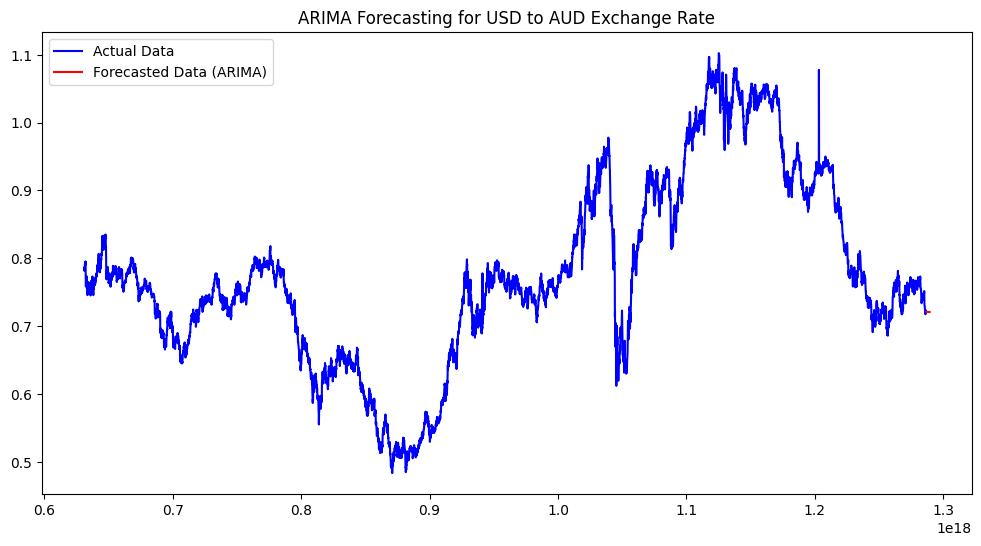

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


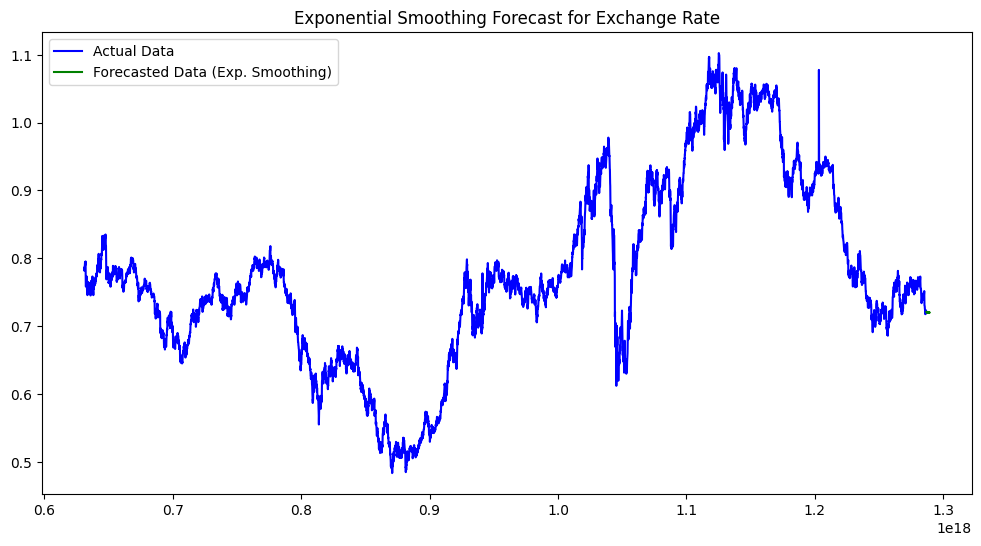

MAE: 0.0127, RMSE: 0.0170
MAE: 0.0130, RMSE: 0.0172


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.units as munits  # Fix unit conflicts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv("exchange_rate.csv")

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

# Clear Matplotlib's unit registry to prevent conflicts
munits.registry.clear()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

# Perform ADF Test (Check Stationarity)
result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary, differencing needed.")

# Differencing to make data stationary
df_diff = df['Ex_rate'].diff().dropna()

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(df_diff, lags=30, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_diff, lags=30, ax=axes[1])
plt.show()

# ARIMA Model
d = 1  # Differencing order (since we differenced once)
model = ARIMA(df['Ex_rate'], order=(5, d, 2))  # Example parameters (p=5, d=1, q=2)
model_fit = model.fit()

# Forecast using ARIMA
forecast_steps = 30  # Forecast for the next 30 days
forecast_arima = model_fit.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual Data', color='blue')
plt.plot(forecast_dates, forecast_arima, label='Forecasted Data (ARIMA)', color='red')
plt.title("ARIMA Forecasting for USD to AUD Exchange Rate")
plt.legend()
plt.show()

# Exponential Smoothing (Holt-Winters)
exp_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
exp_fit = exp_model.fit()
forecast_exp = exp_fit.forecast(steps=forecast_steps)

# Plot Exponential Smoothing forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual Data', color='blue')
plt.plot(forecast_dates, forecast_exp, label='Forecasted Data (Exp. Smoothing)', color='green')
plt.title("Exponential Smoothing Forecast for Exchange Rate")
plt.legend()
plt.show()

# Model Evaluation
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Evaluate ARIMA (using last 30 days for comparison)
evaluate_forecast(df['Ex_rate'][-30:], model_fit.forecast(steps=30))

# Evaluate Exponential Smoothing
evaluate_forecast(df['Ex_rate'][-30:], exp_fit.forecast(steps=30))